# Transmission Line Model

Based on Matlab code frω Brad Story

Brad's version is based on Sondhi and Schroeter (1987) and Story, Laukkanen, and Titze (2000).

### Imports

In [78]:
using Plots

### Parameters

In [79]:
area_function = fill(1, 44) # cross sectional area as a function of distance from glottis
length_function = fill(.4, 44) # length of each tublet in area function
cutoff = 45 # the hard walled tube to extend the vocal tract (only used for impedance studies and normally set to n+1)
max_frequency = 5000 # ceiling in frequency response

r = 408 # ratio of yielding wall resistance to mass
fw = 15 # mechanical resonance frequency of the wall
ft = 200 # lowest resonant frequency of the tract when closed on both ends 

q = 4.0 # correction for thermal conductivity and viscosity normally set to 4 rad/s
c = 35000.0 # speed of sound
ρ = 0.00114 # density of air

println("Parameters set")

Parameters set


### Preliminary Calculations

In [80]:
n_sections = length(area_function) # number of sections in area function
n_points = Int64(round(max_frequency/5)) # maximum points in frequency spectrum
delta_f = max_frequency/n_points
frequencies = [delta_f:delta_f:delta_f*n_points;] # the frequencies at which response and impedance are calculated
n_frequencies = length(frequencies) # number of frequencies at which ...
ω = (2*π) .* frequencies # TODO define the rest below
α = zeros(n_frequencies, 1) + im*(q*ω) 
α = sqrt.(α)
temp1 = r*ones(n_frequencies, 1) + im*(ω)
temp2 = zeros(n_frequencies, 1) + im*(ω)
den = temp1 .* temp2
temp1 = ((2*π*fw)^2)*ones(n_frequencies, 1) + im*zeros(n_frequencies, 1)
den = den + temp1
num = zeros(n_frequencies, 1) + im*ω*(2*π*ft)^2
β = (num ./ den) + α

print("Preliminary calculations complete")

Preliminary calculations complete

### Main Loop

In [81]:
# These are the ABCD matrices that make up the chain matrix for the vocal tract.
# They are based on electrical transmission line theory.

A = ones(n_points, 1);
C = zeros(n_points, 1);
B = zeros(n_points, 1);
D = ones(n_points, 1);

for k in 1:n_sections
# for k in 1:3
    # println("iteration ", k)

    temp1 = r*ones(n_frequencies, 1) + im*(ω)
    temp2 = β + (zeros(n_frequencies, 1) + im*ω)
    γ = sqrt.(temp1 ./ temp2)
    σ = γ .* temp2

    nA = cosh.((length_function[k]/c) * σ)
	temp1 = -ρ*c/area_function[k] * γ
	nB = temp1 .* sinh.( (length_function[k]/c) * σ)
	temp1 = ones(length(γ), 1) ./ γ
	temp2 = -area_function[k]/(ρ*c) * temp1
	nC = temp2 .* sinh.((length_function[k]/c) * σ)
	nD = nA

    M1 = [A B; C D]
    M2 = [nA nB; nC nD]

    # println("M1: ", M1)
    # println(size(M1))
    # println("M2: ", M2)
    # println(size(M2))

    # M1 = vcat([A B], [C D])
    # M2 = vcat([nA nB], [nC nD])

    A = M2[1:n_points, 1].*M1[1:n_points, 1] + M2[1:n_points, 2].*M1[n_points+1:end, 1]
    B = M2[1:n_points, 1].*M1[1:n_points, 2] + M2[1:n_points, 2].*M1[n_points+1:end, 2]
    C = M2[n_points+1:end, 1].*M1[1:n_points, 1] + M2[n_points+1:end, 2].*M1[n_points+1:end, 1]
    D = M2[n_points+1:end, 1].*M1[1:n_points, 2] + M2[n_points+1:end, 2].*M1[n_points+1:end, 2]

    # println("A: ",A)
    # println("B: ",B)
    
end
println("Finished loop")

Finished loop


### Final Calculations

In [82]:
R = 128 .* ρ*c/(9*π^2 * area_function[n_sections])    
L = 8 .* ρ*c/((3*π*c)*sqrt.(area_function[n_sections]*π)) 	
  
temp1 = zeros(n_points, 1) + im*R*L*ω
temp2 = R*ones(n_points, 1) + im*L*ω
Zrad = temp1 ./ temp2

temp1 = (Zrad .* D) - B
temp2 = A - (C .* Zrad)
z = temp1 ./ temp2
h = Zrad ./ temp2
f = frequencies

S = temp2 ./ temp1

h_alt = (-C .* B) ./ A+D

println("Calculations complete")

Calculations complete


### Plots

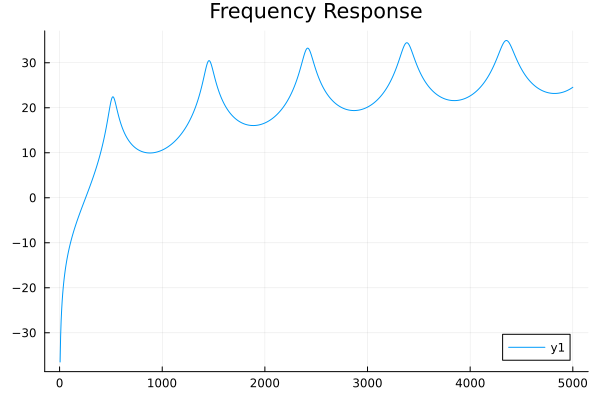

In [83]:
plot(f, 20 .* log10.(abs.(h)), title="Frequency Response")

MATLAB frequency response for comparison
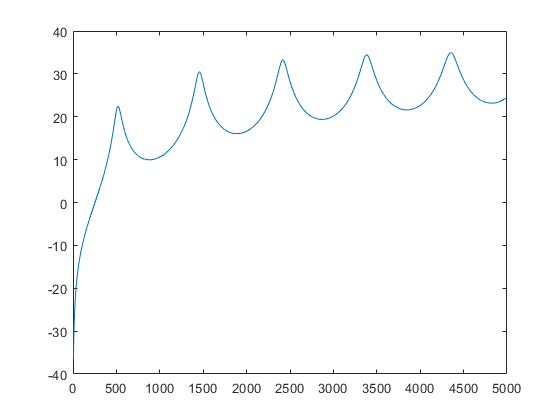

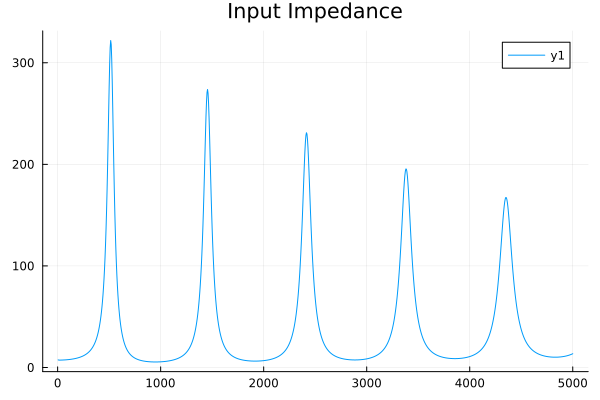

In [84]:
plot(f, real(z), title="Input Impedance")

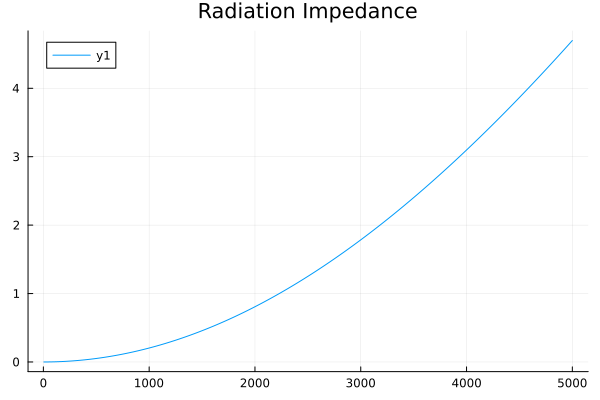

In [85]:
plot(f, real(Zrad), title="Radiation Impedance")

### Demonstrations from Fant
#### Russian vowels

In [110]:
include("../utils.jl")

transmission_line_model

In [111]:
# a
area = [
    5,
    5,
    5,
    5,
    6.5,
    8,
    8,
    8,
    8,
    8,
    8,
    8,
    8,
    6.5,
    5,
    4,
    3.2,
    1.6,
    2.6,
    2.6,
    2,
    1.6,
    1.3,
    1,
    0.65,
    0.65,
    0.65,
    1,
    1.6,
    2.6,
    4,
    1,
    1.3,
    1.6,
    2.6,
]

# Need to reverse the area function because Fant uses lips -> glottis
f, h, z, zrad = transmission_line_model(reverse(area), fill(.5,35), 36)

([5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0  …  4955.0, 4960.0, 4965.0, 4970.0, 4975.0, 4980.0, 4985.0, 4990.0, 4995.0, 5000.0], ComplexF64[0.0005073182132673335 + 0.006928211425505209im; 0.0007061315328327635 + 0.013421526656371778im; … ; -5.502566529516354 - 1.9543093104860536im; -5.590442003366089 - 1.8826741544050467im;;], ComplexF64[3.719004064220676 + 0.1549342109849785im; 3.662141303426871 + 0.4826657404834413im; … ; 6.045220557695979 - 32.04296330708819im; 6.118794782354642 - 31.86328397854384im;;], ComplexF64[5.116305759477727e-6 + 0.00767031945423015im; 2.0465195721537435e-5 + 0.015340618432229917im; … ; 3.5359815213500037 + 5.306418026293012im; 3.5408832213144175 + 5.308460192648369im;;])

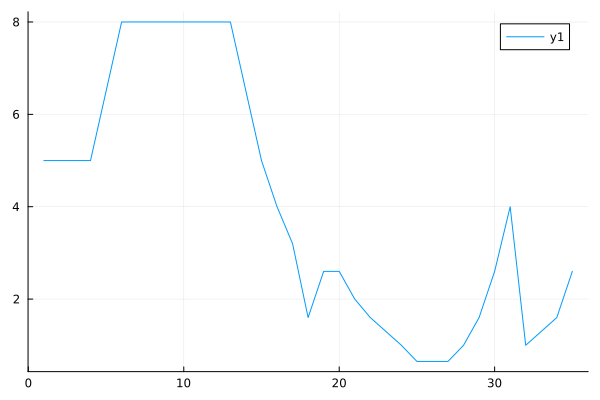

In [112]:
plot(area)

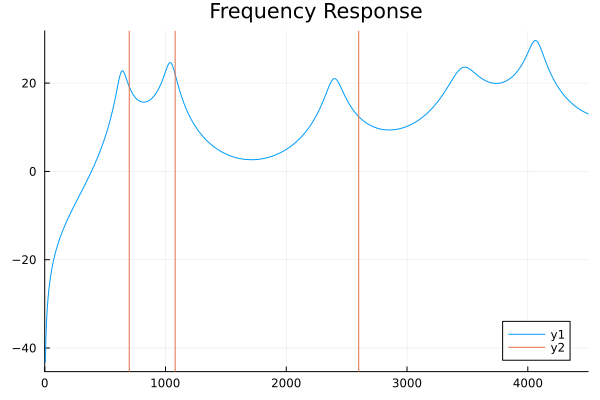

In [113]:
plot(f, 20 .* log10.(abs.(h)), title="Frequency Response", xlim=(0, 4500))
vline!([700, 1080, 2600])